### 梯度裁剪
可以将梯度下降的过程想想为一个人在山上探步寻找谷底的过程
- 危险情况：突然踩到悬崖，按照计算算出的步长，可能直接飞出山谷
- 裁剪的作用：在脚迈出去之前，先检查一下步长是否太大

#### 1. 全局范数裁剪
- 将模型所有层的梯度打包看作巨大的向量，计算它的L2范数
- 设定阈值，通常为1.0
- 如果总长度（L2范数）超过了阈值，就将所有梯度等比例缩小
$$ g_new = g * \frac{\theta}{\|g\|} $$
- 这种方式保持了梯度的方向不变，只是缩小了模场，优化复杂的路径

#### 2. 值裁剪
- 强行将每个梯度的值限制在一个固定的范围内，例如[-c, c]
- 但是这会改变梯度的方向

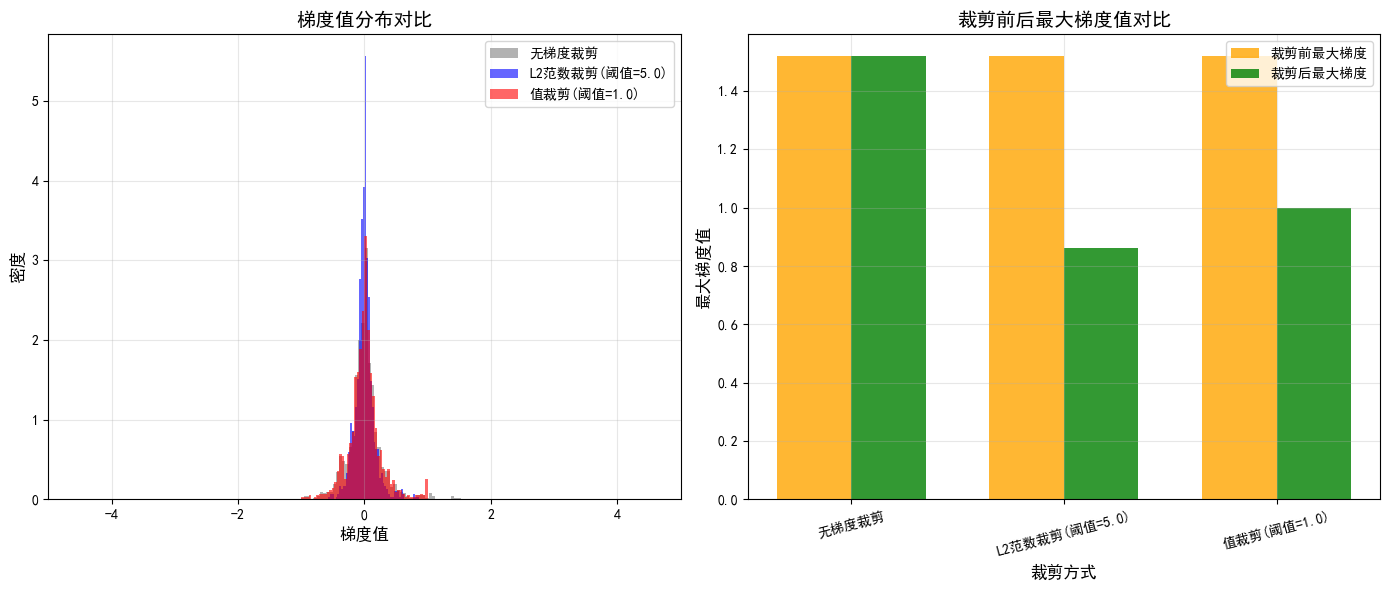

=== 梯度裁剪统计信息 ===

无梯度裁剪:
  裁剪前最大梯度: 1.5200
  裁剪后最大梯度: 1.5200
  被裁剪参数数: 0/4

L2范数裁剪(阈值=5.0):
  裁剪前最大梯度: 1.5200
  裁剪后最大梯度: 0.8606
  被裁剪参数数: 4/4
  缩放比例: 0.5662

值裁剪(阈值=1.0):
  裁剪前最大梯度: 1.5200
  裁剪后最大梯度: 1.0000
  被裁剪参数数: 1/4
Epoch [1/20], 平均损失: 2.5095, 平均最大梯度: 0.3700
Epoch [2/20], 平均损失: 2.3514, 平均最大梯度: 0.2039
Epoch [3/20], 平均损失: 2.3251, 平均最大梯度: 0.1432
Epoch [4/20], 平均损失: 2.3178, 平均最大梯度: 0.1109
Epoch [5/20], 平均损失: 2.3130, 平均最大梯度: 0.0900
Epoch [6/20], 平均损失: 2.3090, 平均最大梯度: 0.0840
Epoch [7/20], 平均损失: 2.3091, 平均最大梯度: 0.0866
Epoch [8/20], 平均损失: 2.3062, 平均最大梯度: 0.0812
Epoch [9/20], 平均损失: 2.3045, 平均最大梯度: 0.0867
Epoch [10/20], 平均损失: 2.3053, 平均最大梯度: 0.0798
Epoch [11/20], 平均损失: 2.3038, 平均最大梯度: 0.0752
Epoch [12/20], 平均损失: 2.3040, 平均最大梯度: 0.0762
Epoch [13/20], 平均损失: 2.3034, 平均最大梯度: 0.0768
Epoch [14/20], 平均损失: 2.3033, 平均最大梯度: 0.0698
Epoch [15/20], 平均损失: 2.3033, 平均最大梯度: 0.0773
Epoch [16/20], 平均损失: 2.3043, 平均最大梯度: 0.0736
Epoch [17/20], 平均损失: 2.3037, 平均最大梯度: 0.0734
Epoch [18/20], 平均损失: 2.3032, 平均最大梯度: 0.0

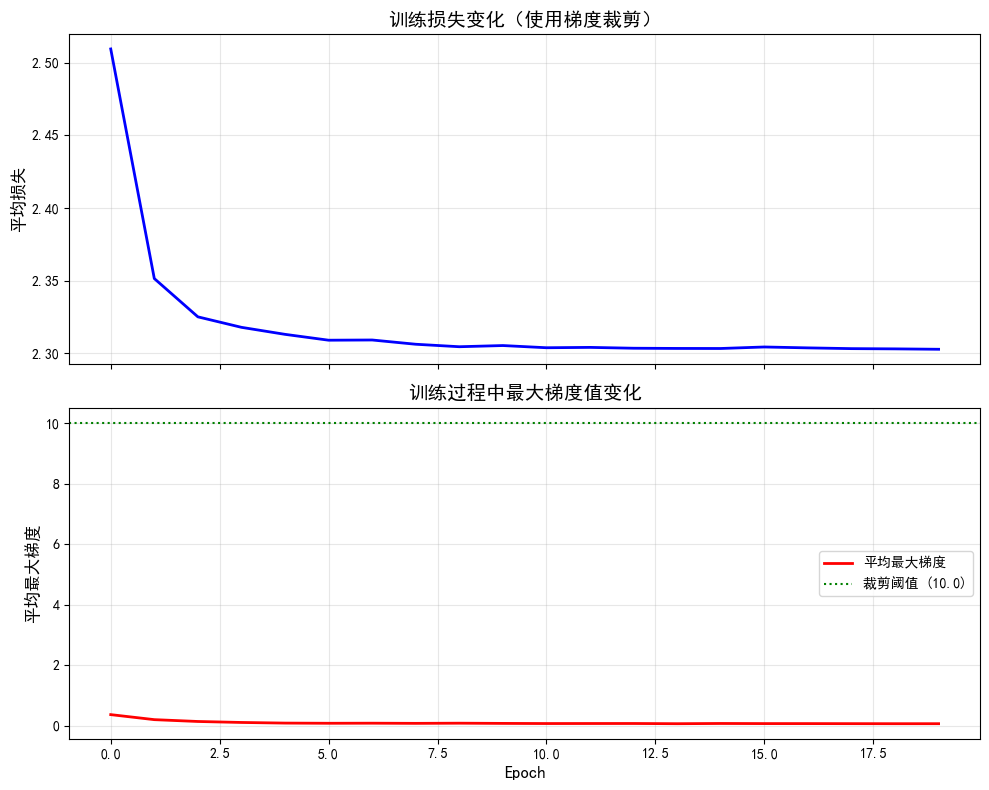


=== 手动实现 vs PyTorch官方梯度裁剪 ===
手动裁剪后最大梯度: 0.2107
官方裁剪后最大梯度: 0.2107
结果是否一致: True


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 支持中文
plt.rcParams['axes.unicode_minus'] = False


def gradient_clipping(parameters, clip_type="norm", clip_value=1.0):
    """
    手动实现梯度裁剪
    参数说明：
        parameters: 模型参数列表（iterable of nn.Parameter）
        clip_type: 裁剪类型 - "norm"（按范数裁剪）/ "value"（按值裁剪）
        clip_value: 裁剪阈值（范数阈值或值范围）
    返回：
        clip_stats: 裁剪统计信息（最大梯度、裁剪比例等）
    """
    if clip_type not in ["norm", "value"]:
        raise ValueError(f"不支持的裁剪类型: {clip_type}，可选 'norm' 或 'value'")
    
    clip_stats = {
        "before_max_grad": 0.0,  # 裁剪前最大梯度值
        "after_max_grad": 0.0,   # 裁剪后最大梯度值
        "clip_ratio": 0.0,       # 范数裁剪时的缩放比例（仅norm类型有效）
        "clipped_params": 0,      # 被裁剪的参数数量
        "total_params": 0         # 总参数数量
    }
    
    # 收集所有梯度（排除无梯度的参数）
    grads = []
    for p in parameters:
        if p.grad is not None:
            grads.append(p.grad.data)
            clip_stats["total_params"] += 1
    
    if not grads:
        return clip_stats
    
    # 记录裁剪前的最大梯度值
    clip_stats["before_max_grad"] = max(torch.max(torch.abs(g)) for g in grads).item()
    
    if clip_type == "norm":
        # 方式1：按范数裁剪（L2范数）
        # 计算所有梯度拼接后的总L2范数
        total_norm = torch.norm(torch.cat([g.reshape(-1) for g in grads]), p=2)
        clip_stats["clip_ratio"] = clip_value / (total_norm + 1e-6)
        
        # 只有当总范数超过阈值时才裁剪
        if total_norm > clip_value:
            clip_stats["clipped_params"] = clip_stats["total_params"]
            # 按比例缩放所有梯度
            for g in grads:
                g.mul_(clip_stats["clip_ratio"])
    
    elif clip_type == "value":
        # 方式2：按值裁剪（将梯度限制在 [-clip_value, clip_value] 范围内）
        for g in grads:
            # 裁剪梯度值
            clipped_g = torch.clamp(g, -clip_value, clip_value)
            # 判断是否有梯度被裁剪
            if not torch.equal(g, clipped_g):
                clip_stats["clipped_params"] += 1
            # 更新梯度
            g.copy_(clipped_g)
    
    # 记录裁剪后的最大梯度值
    clip_stats["after_max_grad"] = max(torch.max(torch.abs(g)) for g in grads).item()
    
    return clip_stats

# 测试案例1：可视化梯度裁剪效果 
def test_gradient_clipping_visual():
    """可视化不同裁剪方式对梯度分布的影响"""
    # 1. 构建简单模型
    model = nn.Sequential(
        nn.Linear(10, 50),
        nn.ReLU(),
        nn.Linear(50, 10)
    )
    
    # 2. 模拟易产生梯度爆炸的输入和损失
    torch.manual_seed(42)
    x = torch.randn(32, 10) * 10  # 放大输入，制造梯度爆炸
    y = torch.randint(0, 10, (32,))
    criterion = nn.CrossEntropyLoss()
    
    # 3. 分三组测试：无裁剪、范数裁剪、值裁剪
    test_cases = [
        {"name": "无梯度裁剪", "clip_type": None, "clip_value": 0.0},
        {"name": "L2范数裁剪(阈值=5.0)", "clip_type": "norm", "clip_value": 5.0},
        {"name": "值裁剪(阈值=1.0)", "clip_type": "value", "clip_value": 1.0}
    ]
    
    # 存储梯度分布数据
    grad_distributions = []
    stats_list = []
    
    for case in test_cases:
        # 重置模型参数和梯度
        model.zero_grad()
        for p in model.parameters():
            if p.grad is not None:
                p.grad.data.zero_()
        
        # 前向传播 + 反向传播
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        
        # 执行梯度裁剪（如果需要）
        if case["clip_type"] is not None:
            stats = gradient_clipping(model.parameters(), case["clip_type"], case["clip_value"])
        else:
            # 收集无裁剪时的统计信息
            stats = {
                "before_max_grad": max(torch.max(torch.abs(p.grad.data)) for p in model.parameters() if p.grad is not None).item(),
                "after_max_grad": max(torch.max(torch.abs(p.grad.data)) for p in model.parameters() if p.grad is not None).item(),
                "clipped_params": 0,
                "total_params": sum(1 for p in model.parameters() if p.grad is not None)
            }
        
        stats_list.append(stats)
        
        # 收集所有梯度值用于可视化
        all_grads = []
        for p in model.parameters():
            if p.grad is not None:
                all_grads.extend(p.grad.data.cpu().numpy().flatten())
        
        grad_distributions.append({
            "name": case["name"],
            "grads": all_grads
        })
    
    # 4. 可视化梯度分布
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # 子图1：梯度值分布直方图
    colors = ["gray", "blue", "red"]
    for i, dist in enumerate(grad_distributions):
        ax1.hist(dist["grads"], bins=50, alpha=0.6, label=dist["name"], color=colors[i], density=True)
    
    ax1.set_title('梯度值分布对比', fontsize=14)
    ax1.set_xlabel('梯度值', fontsize=12)
    ax1.set_ylabel('密度', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(-5, 5)  # 限制x轴范围，更清晰展示
    
    # 子图2：裁剪前后最大梯度值对比
    cases_names = [case["name"] for case in test_cases]
    before_max = [stats["before_max_grad"] for stats in stats_list]
    after_max = [stats["after_max_grad"] for stats in stats_list]
    
    x_pos = np.arange(len(cases_names))
    width = 0.35
    ax2.bar(x_pos - width/2, before_max, width, label='裁剪前最大梯度', color='orange', alpha=0.8)
    ax2.bar(x_pos + width/2, after_max, width, label='裁剪后最大梯度', color='green', alpha=0.8)
    
    ax2.set_title('裁剪前后最大梯度值对比', fontsize=14)
    ax2.set_xlabel('裁剪方式', fontsize=12)
    ax2.set_ylabel('最大梯度值', fontsize=12)
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(cases_names, rotation=15)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('gradient_clipping_visual.png', dpi=300, bbox_inches='tight')
    plt.show()
    
 
    print("=== 梯度裁剪统计信息 ===")
    for i, case in enumerate(test_cases):
        stats = stats_list[i]
        print(f"\n{case['name']}:")
        print(f"  裁剪前最大梯度: {stats['before_max_grad']:.4f}")
        print(f"  裁剪后最大梯度: {stats['after_max_grad']:.4f}")
        print(f"  被裁剪参数数: {stats['clipped_params']}/{stats['total_params']}")
        if case["clip_type"] == "norm":
            print(f"  缩放比例: {stats['clip_ratio']:.4f}")

# 测试案例2：训练中使用梯度裁剪
def train_with_gradient_clipping():
    """模拟完整训练流程中使用梯度裁剪"""
    # 1. 构建模型、优化器、损失函数
    model = nn.Sequential(
        nn.Linear(20, 100),
        nn.ReLU(),
        nn.Linear(100, 50),
        nn.ReLU(),
        nn.Linear(50, 10)
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    
    # 2. 训练参数
    epochs = 20
    steps_per_epoch = 50
    clip_config = {
        "type": "norm",  # 使用范数裁剪
        "value": 10.0    # 裁剪阈值
    }
    
    # 记录训练过程
    loss_history = []
    max_grad_history = []
    clip_ratio_history = []
    
    # 3. 训练循环
    for epoch in range(epochs):
        epoch_loss = 0.0
        epoch_max_grad = 0.0
        epoch_clip_ratio = 0.0
        
        for step in range(steps_per_epoch):
            # 模拟训练数据（放大输入，制造梯度爆炸风险）
            x = torch.randn(64, 20) * 15
            y = torch.randint(0, 10, (64,))
            
            # 前向传播
            outputs = model(x)
            loss = criterion(outputs, y)
            
            # 反向传播
            optimizer.zero_grad()
            loss.backward()
            
            # 执行梯度裁剪
            stats = gradient_clipping(model.parameters(), clip_config["type"], clip_config["value"])
            
            # 更新参数
            optimizer.step()
            
            # 记录数据
            epoch_loss += loss.item()
            epoch_max_grad += stats["after_max_grad"]
            if stats["clip_ratio"] > 0:
                epoch_clip_ratio += stats["clip_ratio"]
        
        # 计算epoch平均数据
        avg_loss = epoch_loss / steps_per_epoch
        avg_max_grad = epoch_max_grad / steps_per_epoch
        avg_clip_ratio = epoch_clip_ratio / steps_per_epoch
        
        loss_history.append(avg_loss)
        max_grad_history.append(avg_max_grad)
        clip_ratio_history.append(avg_clip_ratio)
        
        # 打印epoch信息
        print(f"Epoch [{epoch+1}/{epochs}], 平均损失: {avg_loss:.4f}, 平均最大梯度: {avg_max_grad:.4f}")
    
    # 4. 可视化训练过程
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    # 损失曲线
    ax1.plot(loss_history, color='blue', linewidth=2)
    ax1.set_title('训练损失变化（使用梯度裁剪）', fontsize=14)
    ax1.set_ylabel('平均损失', fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # 最大梯度曲线
    ax2.plot(max_grad_history, color='red', linewidth=2, label='平均最大梯度')
    ax2.axhline(y=clip_config["value"], color='green', linestyle=':', label=f'裁剪阈值 ({clip_config["value"]})')
    ax2.set_title('训练过程中最大梯度值变化', fontsize=14)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('平均最大梯度', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 对比PyTorch官方梯度裁剪 
def compare_with_official_clipping():
    """对比手动实现与PyTorch官方梯度裁剪的效果"""
    model = nn.Linear(10, 5)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    
    # 制造梯度
    x = torch.randn(32, 10)
    y = torch.randint(0, 5, (32,))
    criterion = nn.CrossEntropyLoss()
    
    # 手动裁剪
    model.zero_grad()
    outputs = model(x)
    loss = criterion(outputs, y)
    loss.backward()
    manual_stats = gradient_clipping(model.parameters(), "norm", 2.0)
    
    # 重置梯度，使用官方裁剪
    model.zero_grad()
    outputs = model(x)
    loss = criterion(outputs, y)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
    
    # 计算官方裁剪后的最大梯度
    official_max_grad = max(torch.max(torch.abs(p.grad.data)) for p in model.parameters() if p.grad is not None).item()
    
    print("\n=== 手动实现 vs PyTorch官方梯度裁剪 ===")
    print(f"手动裁剪后最大梯度: {manual_stats['after_max_grad']:.4f}")
    print(f"官方裁剪后最大梯度: {official_max_grad:.4f}")
    print(f"结果是否一致: {abs(manual_stats['after_max_grad'] - official_max_grad) < 1e-5}")

if __name__ == "__main__":
    # 测试1：可视化梯度裁剪效果
    test_gradient_clipping_visual()
    
    # 测试2：训练中使用梯度裁剪
    train_with_gradient_clipping()
    
    # 测试3：对比官方实现
    compare_with_official_clipping()